<a href="https://colab.research.google.com/github/dipakp2726/Recipe-Master/blob/devlope/model_mobilenetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libs


In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import tensorflow as tf
 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.4.1


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


# setting path to dataset and parameters

In [4]:
data_dir ='/content/drive/MyDrive/Recipe Master/dataset/dataset' 
data_dir = pathlib.Path(data_dir)

In [47]:
class_names = os.listdir(data_dir)

In [5]:
batch_size = 32
img_height = 224
img_width = 224
IMG_SIZE = (img_height,img_width)

In [66]:
# batch_size = 32
# img_height = 299
# img_width = 299
# IMG_SIZE = (img_height,img_width)

# spliting validation,test and train data

In [67]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.
Using 2400 files for training.


In [68]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [69]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 16
Number of test batches: 3


# printing class names and random images from dataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Handvo', 'Khaman', 'Khandvi', 'Muthiya', 'Thepla', 'Undhiyu']


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# datapreprocessing

In [70]:
# normalizing img weights

rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [71]:
# data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
   
  ]
)

In [ ]:
# augmentation preview
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# model creation

In [72]:
IMG_SHAPE = IMG_SIZE + (3,)

# base_model = tf.keras.applications.ResNet101V2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE, 
#                                                     pooling='max', classes=1000)
# base_model = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_shape=IMG_SHAPE, 
#                                                     pooling='avg', classes=1000)

# base_model= tf.keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=IMG_SHAPE, 
#                                                     pooling='avg', classes=1000)


base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE, alpha=1.0, minimalistic=False, include_top=False,
    weights='imagenet', classes=1000, pooling=None,
    dropout_rate=0.2, classifier_activation='softmax'
)

# base_model = tf.keras.applications.Xception(
#     include_top=True, weights='imagenet', 
#     input_shape=IMG_SHAPE, pooling=None, classes=1000,
#     classifier_activation='softmax'
# )

model_name= "MobileNetV3Large"

# base_model =tf.keras.applications.InceptionV3(
#     include_top=False, weights='imagenet',
#     input_shape=IMG_SHAPE, pooling=max, classes=1000,
#     classifier_activation='softmax'
# )

91889664/91884032 [==============================] - 1s 0us/step


In [73]:
base_model.trainable=False


In [ ]:
base_model.summary()

In [75]:
prediction_layer = tf.keras.layers.Dense(6,activation='softmax')

In [78]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = rescale(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)
x = data_augmentation(inputs)
x = base_model(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)


outputs = tf.keras.layers.Dense(6,activation='softmax')(x)



# outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs )

In [79]:
# base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [80]:
loss0, accuracy0 = model.evaluate(val_ds)

16/16 [==============================] - 13s 469ms/step - loss: 1.7936 - accuracy: 0.1410


In [81]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.79
initial accuracy: 0.16


## Callbacks

In [ ]:
!mkdir checkpoint
checkpoint_path = "/content/checkpoint"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

## traing model

In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
initial_epochs = 38
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

## plotting accuracy

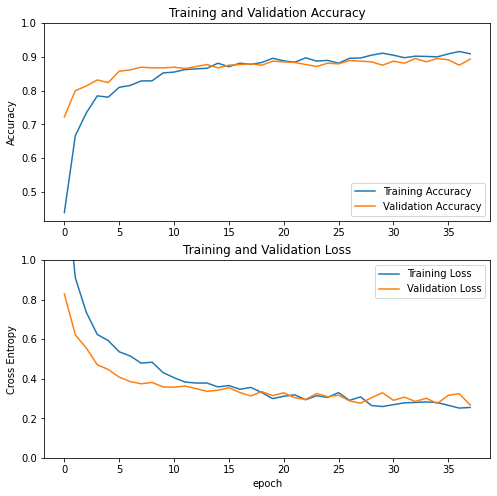

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# sparce_acc = history.history['sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.plot(sparce_acc, label='sparse_categorical_accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:

model.save('/content/drive/MyDrive/Recipe Master/colab/saved model/Xception_first_round +6.h5')

In [30]:

loss0, accuracy0 = model.evaluate(test_ds)

3/3 [==============================] - 4s 278ms/step - loss: 0.4107 - accuracy: 0.8542


In [31]:
print("test loss: {:.2f}".format(loss0))
print("test accuracy: {:.2f}".format(accuracy0))

test loss: 0.41
test accuracy: 0.85


#fine tuning

In [32]:
base_model.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7686      
Total params: 4,234,118
Trainable params: 4,209,718
Non-trainable params: 24,400
____________________________________________

In [33]:
# low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [38]:
epochs = 20
history2 = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/20
75/75 [==============================] - 15s 196ms/step - loss: 0.2574 - accuracy: 0.9083 - val_loss: 0.2168 - val_accuracy: 0.9206
Epoch 2/20
75/75 [==============================] - 15s 198ms/step - loss: 0.2386 - accuracy: 0.9175 - val_loss: 0.2047 - val_accuracy: 0.9266
Epoch 3/20
75/75 [==============================] - 15s 200ms/step - loss: 0.2114 - accuracy: 0.9296 - val_loss: 0.1945 - val_accuracy: 0.9325
Epoch 4/20
75/75 [==============================] - 15s 202ms/step - loss: 0.1946 - accuracy: 0.9358 - val_loss: 0.1863 - val_accuracy: 0.9345
Epoch 5/20
75/75 [==============================] - 15s 201ms/step - loss: 0.1815 - accuracy: 0.9446 - val_loss: 0.1779 - val_accuracy: 0.9365
Epoch 6/20
75/75 [==============================] - 15s 198ms/step - loss: 0.1724 - accuracy: 0.9404 - val_loss: 0.1700 - val_accuracy: 0.9385
Epoch 7/20
75/75 [==============================] - 15s 198ms/step - loss: 0.1488 - accuracy: 0.9521 - val_loss: 0.1589 - val_accuracy: 0.9484

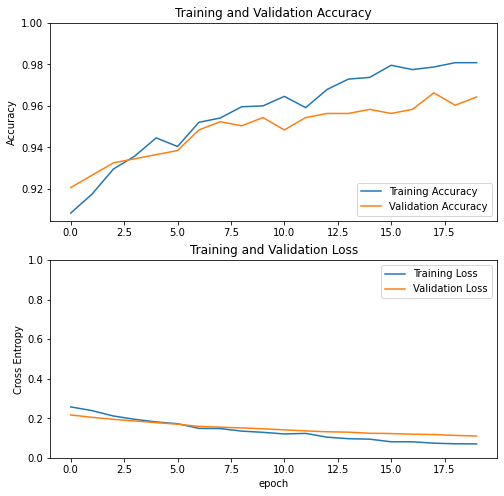

In [39]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
# sparce_acc = history.history['sparse_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.plot(sparce_acc, label='sparse_categorical_accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [59]:

loss0, accuracy0 = model.evaluate(test_ds)

3/3 [==============================] - 0s 46ms/step - loss: 0.1483 - accuracy: 0.9479


In [41]:
model.save('/content/drive/MyDrive/Recipe Master/colab/saved model/Xception_fining_round.h5')

#taking prediction

In [56]:
class_names

['Khaman', 'Thepla', 'Khandvi', 'Undhiyu', 'Muthiya', 'Handvo']

In [60]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT4mWJrdgGAcyLmbuNy4xpisjnZfF7UFNyWKg&usqp=CAU"
path = tf.keras.utils.get_file('Khaman', origin=url)

img = tf.keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[[3.1585549e-04 9.9930382e-01 3.6744590e-04 8.3424784e-06 1.0702983e-06
  3.4335787e-06]]
tf.Tensor([0.12962353 0.35199687 0.12963022 0.12958369 0.12958273 0.12958305], shape=(6,), dtype=float32)
This image most likely belongs to Thepla with a 35.20 percent confidence.
